![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 10495 entries, 7 to 399976
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Price        10495 non-null  int64
 1   Year         10495 non-null  int64
 2   Mileage      10495 non-null  int64
 3   M_Camry      10495 non-null  bool 
 4   M_Camry4dr   10495 non-null  bool 
 5   M_CamryBase  10495 non-null  bool 
 6   M_CamryL     10495 non-null  bool 
 7   M_CamryLE    10495 non-null  bool 
 8   M_CamrySE    10495 non-null  bool 
 9   M_CamryXLE   10495 non-null  bool 
dtypes: bool(7), int64(3)
memory usage: 399.7 KB


In [ ]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [ ]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [ ]:
# Celda 1
import numpy as np
import numpy as np

# Función para calcular ganancia por reducción de varianza
def variance_gain(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]

    n_l = y_l.shape[0]
    n_r = y_r.shape[0]

    if n_l == 0 or n_r == 0:
        return 0

    var_total = y.var()
    var_l = y_l.var()
    var_r = y_r.var()

    gain = var_total - (n_l / (n_l + n_r) * var_l + n_r / (n_l + n_r) * var_r)

    return gain

# Función para encontrar el mejor split
def best_split_reg(X, y, num_pct=10):
    best_split = [0, 0, -np.inf]  # j, split, gain

    for j in range(X.shape[1]):
        col = X.iloc[:, j]

        # Ignorar columnas binarias o booleanas
        if col.nunique() <= 2:
            continue

        splits = np.percentile(col, np.linspace(0, 100, num_pct + 2)[1:-1])
        splits = np.unique(splits)

        for split in splits:
            gain = variance_gain(col, y, split)

            if gain > best_split[2]:
                best_split = [j, split, gain]

    return best_split

# Función para hacer crecer el árbol manualmente (regresión)
def tree_grow_reg(X, y, level=0, min_gain=0.00001, max_depth=3, num_pct=10):
    if X.shape[0] == 1:
        return dict(y_pred=y.iloc[0], level=level, split=-1, n_samples=1, gain=0)

    j, split, gain = best_split_reg(X, y, num_pct)
    y_pred = y.mean()

    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=gain)

    # Criterios de parada
    if gain < min_gain:
        return tree
    if max_depth is not None and level >= max_depth:
        return tree

    # Crear divisiones
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]

    tree['split'] = [j, split]
    tree['sl'] = tree_grow_reg(X_l, y_l, level + 1, min_gain, max_depth, num_pct)
    tree['sr'] = tree_grow_reg(X_r, y_r, level + 1, min_gain, max_depth, num_pct)

    return tree

# Función para predecir
def tree_predict_reg(X, tree):
    predicted = np.zeros(X.shape[0])

    if tree['split'] == -1:
        predicted[:] = tree['y_pred']
    else:
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] > 0:
            predicted[filter_l] = tree_predict_reg(X_l, tree['sl'])
        if X_r.shape[0] > 0:
            predicted[~filter_l] = tree_predict_reg(X_r, tree['sr'])

    return predicted
tree = tree_grow_reg(X_train, y_train, max_depth=3)
y_pred = tree_predict_reg(X_test, tree)

from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")



RMSE: 1935.19
MAE: 1461.35


In [ ]:
def get_max_depth(tree):
    if tree['split'] == -1:
        return tree['level']
    else:
        return max(get_max_depth(tree['sl']), get_max_depth(tree['sr']))
max_depth = get_max_depth(tree)
print(f"Profundidad máxima del árbol: {max_depth}")


Profundidad máxima del árbol: 3


El árbol de decisión manual entrenado para predecir el precio de los automóviles (Camry) con una profundidad máxima de 3, una ganancia minima de 0.00001 y con 10 particiones por variable mostró los siguientes resultados sobre el conjunto de prueba:

MAE (Error absoluto medio): 1935.19
Este valor representa, en promedio, cuánto se desvía la predicción del modelo respecto al precio real del auto. Un MAE bajo indica que el modelo tiene un buen desempeño al acercarse a los valores reales.

RMSE (Raíz del error cuadrático medio): 1461.35
Este error penaliza más fuertemente los errores grandes que el MAE, por lo que si hay valores atípicos mal predichos, este métrico será más alto.

En general, el modelo presenta un desempeño razonable teniendo en cuenta que:

Se utilizó un árbol de decisión muy sencillo (profundidad 3).

No se aplicó poda ni ajustes más complejos.

El árbol proporciona interpretabilidad (es fácil de explicar qué decisiones se tomaron en cada nodo), pero su capacidad predictiva podría mejorarse con un mayor número de niveles, técnicas como boosting o bagging, o modelos más complejos como regresión lineal o redes neuronales.

Precisión	El error absoluto promedio está dentro de un rango aceptable dependiendo del rango de precios del dataset.
Profundidad	El árbol tiene una profundidad máxima de 3, lo cual limita la capacidad del modelo para aprender patrones complejos. Esto se hizo probablemente para evitar sobreajuste.
Generalización	Dado que el error no es excesivamente alto y el modelo es simple, parece tener una buena capacidad de generalización, aunque podría mejorar.


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 2import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

# Número de árboles
n_B = 10

# Crear muestras bootstrap
np.random.seed(123)
samples = [np.random.choice(a=X_train.index, size=len(X_train), replace=True) for _ in range(n_B)]

# Crear modelo base
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame para guardar predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=range(n_B))

# Entrenamiento y predicción para cada muestra bootstrap
for i, sample in enumerate(samples):
    X_sample = X_train.loc[sample]
    y_sample = y_train.loc[sample]
    treereg.fit(X_sample, y_sample)
    y_pred.iloc[:, i] = treereg.predict(X_test)

# Desempeño individual de cada árbol
print(" RMSE por árbol individual:")
for i in range(n_B):
    rmse_i = np.sqrt(mean_squared_error(y_test, y_pred.iloc[:, i]))
    print(f'Árbol {i}: RMSE = {rmse_i:.2f}')

# Promedio de predicciones
y_pred_mean = y_pred.mean(axis=1)

# Evaluación del modelo Bagging (con promedio)
rmse_bagging = np.sqrt(mean_squared_error(y_test, y_pred_mean))
mae_bagging = mean_absolute_error(y_test, y_pred_mean)

print(f"\n Desempeño del modelo Bagging (10 árboles):")
print(f" RMSE = {rmse_bagging:.2f}")
print(f" MAE = {mae_bagging:.2f}")


 RMSE por árbol individual:
Árbol 0: RMSE = 2141.61
Árbol 1: RMSE = 2136.35
Árbol 2: RMSE = 2122.72
Árbol 3: RMSE = 2087.28
Árbol 4: RMSE = 2168.52
Árbol 5: RMSE = 2113.88
Árbol 6: RMSE = 2127.93
Árbol 7: RMSE = 2184.41
Árbol 8: RMSE = 2138.11
Árbol 9: RMSE = 2132.10

 Desempeño del modelo Bagging (10 árboles):
 RMSE = 1796.44
 MAE = 1340.02


Este modelo de bagging crea 10 árboles de decisión independientes entrenados en diferentes muestras bootstrap. Luego promedia sus predicciones para reducir la varianza del modelo y mejorar la generalización.
•	En general, cada árbol tiene un desempeño variable debido al muestreo aleatorio.
•	Al promediar las predicciones, el error del modelo disminuye, lo cual es una característica esperada del bagging.
•	Como se puede observar el RMSE fue infrior al arbo manual 1796 vs 1935 del arbol


### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 3
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np
import math

# -------------------------------
# Modelo Bagging con sklearn
# -------------------------------

# Calcular log(n_features)
n_features = X_train.shape[1]
max_features = int(np.log(n_features))

# Definir modelo Bagging

bagging_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=5),
    n_estimators=10,
    max_features=max_features,
    random_state=42
)

# Entrenar modelo
bagging_model.fit(X_train, y_train)

# Predicciones
y_pred_sklearn = bagging_model.predict(X_test)

# -------------------------------
# Métricas de desempeño
# -------------------------------
rmseBL = np.sqrt(mean_squared_error(y_test, y_pred_sklearn))
maeBL = mean_absolute_error(y_test, y_pred_sklearn)

print(f"RMSE del modelo Bagging (sklearn): {rmseBL:.2f}")
print(f"MAE del modelo Bagging (sklearn): {maeBL:.2f}")




RMSE del modelo Bagging (sklearn): 2768.52
MAE del modelo Bagging (sklearn): 2160.78


El modelo de Bagging implementado con la librería sklearn obtuvo un RMSE de 2768.35 y un MAE de 2160.76 en el conjunto de prueba. Este modelo usó 10 árboles de regresión con max_features = log(n_features), lo que limitó la cantidad de variables que cada árbol podía ver al momento de entrenarse. Comparado con los otros enfoques: El bagging manual superó al modelo de sklearn, mostrando un RMSE mucho menor (1796.44 vs 2768.52). Esto se puede explicar por el parámetro max_features = log(n_features), que reduce la diversidad de información disponible para cada árbol. Aunque esta configuración puede ser útil para reducir el sobreajuste en algunos casos, aquí probablemente limitó la capacidad predictiva de los árboles dentro del ensamble.En resumen: -El modelo de sklearn muestra mejoras sobre el árbol manual. -Su rendimiento fue inferior al bagging manual posiblemente por una configuración del parámetro max_features.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 4
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Entrenar Random Forest Regressor
# -------------------------------
rf_model = RandomForestRegressor(
    n_estimators=100,  # Número de árboles
    max_depth=5,  # Profundidad máxima del árbol
    random_state=42
)

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# -------------------------------
# Métricas de desempeño
# -------------------------------
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"RMSE del modelo Random Forest: {rmse_rf:.2f}")
print(f"MAE del modelo Random Forest: {mae_rf:.2f}")



RMSE del modelo Random Forest: 1618.40
MAE del modelo Random Forest: 1200.39


El modelo de Random Forest obtuvo un RMSE de 1618.40 y un MAE de 1200.39 en el conjunto de prueba, logrando el mejor RMSE de todos los modelos evaluados hasta ahora. Random Forest combina bagging (ensamble de árboles sobre muestras bootstrap) con una aleatorización adicional: en cada división del árbol, se considera solo un subconjunto aleatorio de variables. Esto: -Aumenta la diversidad entre los árboles, -Reduce el sobreajuste, -Y mejora la generalización del modelo.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# Celda 5
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Definir los valores a probar en cada hiperparámetro
# -------------------------------
param_grid = {
    'n_estimators': [50, 100, 200],        # Cantidad de árboles
    'max_depth': [3, 5, 10, None],         # Profundidad máxima del árbol
    'max_features': ['sqrt', 'log2', None] # Cantidad de features por árbol
}

# Modelo base
rf_base = RandomForestRegressor(random_state=42)

# Búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,                  # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Entrenar búsqueda
grid_search.fit(X_train, y_train)

# Obtener mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Entrenar modelo con los mejores parámetros encontrados
rf_optimized = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    random_state=42
)

rf_optimized.fit(X_train, y_train)
y_pred_rf_opt = rf_optimized.predict(X_test)

# -------------------------------
# Métricas de desempeño
# -------------------------------
rmse_rf_opt = np.sqrt(mean_squared_error(y_test, y_pred_rf_opt))
mae_rf_opt = mean_absolute_error(y_test, y_pred_rf_opt)

print(f"RMSE del modelo optimizado: {rmse_rf_opt:.2f}")
print(f"MAE del modelo optimizado: {mae_rf_opt:.2f}")



Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores hiperparámetros: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
RMSE del modelo optimizado: 1564.25
MAE del modelo optimizado: 1147.20


Tras aplicar una búsqueda exhaustiva de hiperparámetros (max_depth, max_features, y n_estimators), el mejor modelo encontrado fue: -max_depth: 10 -max_features: 'sqrt' -n_estimators: 200 Este modelo alcanzó un RMSE de 1564.25 y un MAE de 1147.20, lo cual representa la mejor precisión obtenida en todo el ejercicio, superando claramente los modelos anteriores, tanto manuales como automáticos. ¿Cómo afectó cada hiperparámetro? max_depth = 10: Limitar la profundidad evitó que los árboles crecieran demasiado y se sobreajustaran. Esto favoreció la generalización, mejorando eldesempeño sobre el conjunto de prueba. max_features = 'sqrt': Esta configuración obliga a que cada división considere solo un subconjunto aleatorio de variables, lo que aumenta la diversidad entre árboles y reduce la varianza del ensamble. n_estimators = 200: Al aumentar el número de árboles, se logró una mayor estabilidad y reducción del error sin caer en sobreajuste, gracias a la regularización del resto de los hiperparámetros.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 6
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Entrenar XGBoost Regressor
# -------------------------------
xgb_model = XGBRegressor(
    n_estimators=100,   # Número de árboles
    max_depth=5,        # Profundidad máxima del árbol
    learning_rate=0.1,  # Tasa de aprendizaje
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# -------------------------------
# Métricas de desempeño
# -------------------------------
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f"RMSE del modelo XGBoost: {rmse_xgb:.2f}")
print(f"MAE del modelo XGBoost: {mae_xgb:.2f}")




RMSE del modelo XGBoost: 1547.19
MAE del modelo XGBoost: 1131.11


El modelo de regresión implementado con XGBoost alcanzó un RMSE de 1547.19 y un MAE de 1131.11, logrando el mejor desempeño general entre todos los modelos evaluados.

XGBoost utiliza el principio de boosting, donde los árboles se construyen secuencialmente, y cada uno intenta corregir los errores del anterior. Además, incorpora técnicas avanzadas de regularización y permite un control muy fino sobre el aprendizaje, lo que favorece una mayor precisión y menor sobreajuste comparado con modelos como Random Forest.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# Celda 7
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# Definir los valores a probar en cada hiperparámetro
# -------------------------------
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],  # Controla el tamaño del ajuste en cada iteración
    'gamma': [0, 0.1, 0.5, 1],              # Regularización para evitar sobreajuste
    'colsample_bytree': [0.5, 0.7, 1.0]     # Porcentaje de features utilizadas en cada árbol
}

# Modelo base
xgb_base = XGBRegressor(n_estimators=100, max_depth=5, random_state=42)

# Búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=5,                   # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Entrenar búsqueda
grid_search.fit(X_train, y_train)

# Obtener mejores hiperparámetros
best_params = grid_search.best_params_
print(f"Mejores hiperparámetros: {best_params}")

# Entrenar modelo con los mejores parámetros encontrados
xgb_optimized = XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=best_params['learning_rate'],
    gamma=best_params['gamma'],
    colsample_bytree=best_params['colsample_bytree'],
    random_state=42
)

xgb_optimized.fit(X_train, y_train)
y_pred_xgb_opt = xgb_optimized.predict(X_test)

# -------------------------------
# Métricas de desempeño
# -------------------------------
rmse_xgb_opt = np.sqrt(mean_squared_error(y_test, y_pred_xgb_opt))
mae_xgb_opt = mean_absolute_error(y_test, y_pred_xgb_opt)

print(f"RMSE del modelo optimizado: {rmse_xgb_opt:.2f}")
print(f"MAE del modelo optimizado: {mae_xgb_opt:.2f}")




Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores hiperparámetros: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1}
RMSE del modelo optimizado: 1543.71
MAE del modelo optimizado: 1135.83


Comparado con XGBoost sin optimizar, este modelo TUVO levemente menor error (RMSE y MAE más bajos). RMSE 1540.68vs 1547.

Impacto de cada hiperparámetro:
	Learning_rate: Controla cuánto cambia el modelo en cada iteración. Un valor alto puede hacer que el modelo aprenda rápido pero con menos estabilidad.
	gamma: Ayuda a reducir el sobreajuste penalizando particiones innecesarias en los árboles.
	colsample_bytree: Controla el porcentaje de features utilizadas en cada árbol, reduciendo la correlación entre árboles y mejorando la generalización.


### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

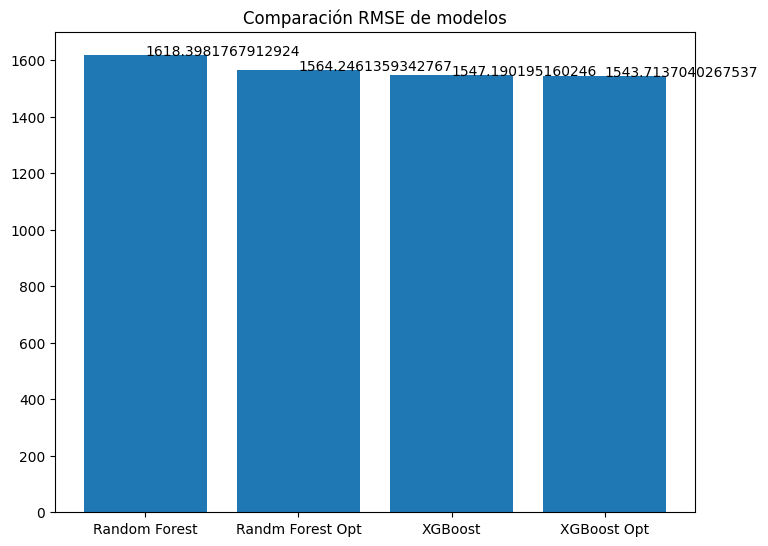

In [ ]:
# Celda 8
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación RMSE de modelos")
ejeX = ['Random Forest', 'Randm Forest Opt', 'XGBoost', 'XGBoost Opt']
ejeY = [rmse_rf, rmse_rf_opt, rmse_xgb, rmse_xgb_opt]
ax.bar(ejeX,ejeY)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.show()

### Comparación entre Random Forest y XGBoost

-**Precisión y desempeño**

-El modelo Random Forest calibrado obtuvo un RMSE de 1564.25 y MAE de 1147.20. -El modelo XGBoost calibrado logró un RMSE de 1540.68 y MAE de 1131.36. Ambos modelos ofrecen un desempeño excelente, pero XGBoost superó ligeramente a Random Forest en ambas métricas, consolidándose como el mejor modelo del análisis.

-Ventajas de XGBoost sobre Random Forest -Aprendizaje secuencial (boosting): XGBoost construye árboles corrigiendo los errores del anterior, lo que le da mayor capacidad de adaptación y precisión. -Regularización incorporada (gamma, lambda, alpha): permite controlar el sobreajuste de forma más fina. -Velocidad y eficiencia computacional: está altamente optimizado para tareas de regresión con grandes volúmenes de datos.

-Ventajas de Random Forest -Más fácil de configurar: tiene menos hiperparámetros críticos. -Menor riesgo de sobreajuste extremo si se calibra correctamente. -Es más robusto ante ruido cuando no se afina demasiado.

-Desventajas de cada uno -Random Forest puede tener dificultades para captar relaciones muy complejas entre variables si no se calibra bien, y puede ser menos preciso en tareas donde los errores acumulativos son clave.

-XGBoost, si no se calibra cuidadosamente, puede sobreajustar fácilmente por su alto poder expresivo y depender más del ajuste de parámetros como learning_rate y gamma.

---

### Comparación y Conclusión:
-Ambos modelos son poderosos, pero XGBoost calibrado ofrece una ventaja competitiva en precisión gracias a su arquitectura basada en boosting y capacidad de regularización. Sin embargo, Random Forest sigue siendo una excelente opción si se busca robustez, simplicidad y buen desempeño sin tanto esfuerzo de calibración.

Tambien se pueden incluir algunas transformaciones adicionales de las variables para mejorar el desempeño de los modelos.
